In [1]:

import importlib
importlib.reload(hsa)

<module 'hsa' from '/E1/taylorm/espr/src/hsa.py'>

In [1]:
import hsa
import numpy as np 
import xarray as xr
import xarray.ufuncs as xu
import bottleneck
import datetime
import os
import paths as ps
import utils as ut
import plot

In [2]:
variable = 'slp'
now = datetime.datetime.now()

with open(ps.log_directory + 'current_run.txt', "r") as f:
    model_date=datetime.datetime.strptime(f.readlines()[-1][5:16],'%Y%m%d_%H')
lons = np.arange(180,310.1,0.5)
lats = np.arange(20,80.1,0.5)
nfa_mean = hsa.NewForecastArray('mean',variable, None)
gefs_mean = nfa_mean._load_all(subset_lat=lats,subset_lon=lons)
nfa_sprd = hsa.NewForecastArray('sprd',variable, None)
gefs_sprd = nfa_sprd._load_all(subset_lat=lats,subset_lon=lons)
print('loading reforecasts')
mc = hsa.MClimate(model_date, variable, None)
mc_mu = hsa.xarr_interpolate(mc.generate(stat='mean',dask=True),gefs_mean)
mc = hsa.MClimate(model_date, variable, None)
mc_std = hsa.xarr_interpolate(mc.generate(stat='sprd',dask=True),gefs_mean)
print('stats time')
percentiles = hsa.percentile_v(mc_mu, gefs_mean)
subset = hsa.subset_sprd_v(percentiles, mc_std)
hsa_final = hsa.hsa_transform(gefs_sprd, subset)
gefs_mean = gefs_mean.rename({'time':'fhour'})
    

loading reforecasts
stats time


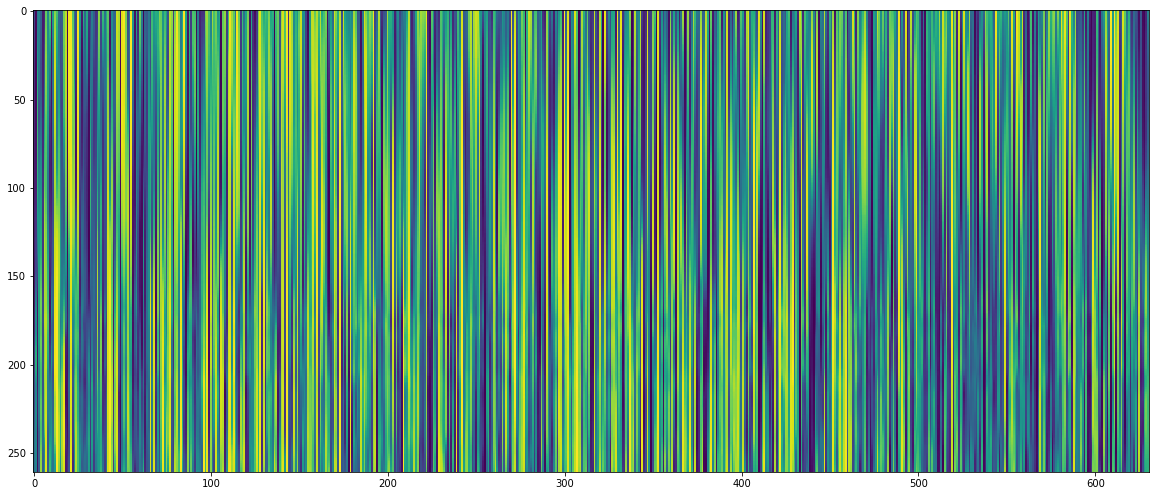

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(percentiles[:,0,0].T)

In [60]:
np.where(percentiles[:,0,1,1]==np.max(percentiles[:,0,1,1]))

(array([300]),)

In [61]:
mc_mu.Pressure[:,0,1,1][300].values

array(104282.203125)

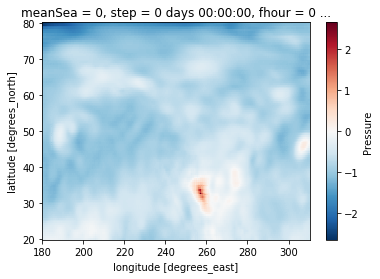

In [62]:
hsa_final['Pressure'][0].plot()

In [63]:
gefs_sprd_n = gefs_sprd.rename({'time':'fhour'})
gefs_sprd_n = gefs_sprd_n.assign_coords(fhour=subset.fhour)
subset_vals = (gefs_sprd_n - subset.mean('time'))/subset.std('time')

In [64]:
gefs_sprd_n['Pressure'].values

array([[[ 33.6942  ,  34.0942  ,  34.494198, ...,  65.0942  ,
          66.2942  ,  67.2942  ],
        [ 33.8942  ,  34.294197,  34.8942  , ...,  69.4942  ,
          70.6942  ,  71.894196],
        [ 34.494198,  35.0942  ,  35.6942  , ...,  70.4942  ,
          71.6942  ,  72.894196],
        ...,
        [ 52.294197,  53.0942  ,  54.0942  , ...,  62.6942  ,
          61.8942  ,  61.0942  ],
        [ 52.8942  ,  53.6942  ,  54.494198, ...,  62.0942  ,
          61.294197,  60.494198],
        [ 53.6942  ,  54.494198,  55.494198, ...,  61.8942  ,
          60.8942  ,  60.294197]],

       [[ 42.882088,  43.202087,  43.682087, ...,  57.76209 ,
          58.08209 ,  58.24209 ],
        [ 42.722088,  43.202087,  43.682087, ...,  73.442085,
          73.442085,  73.28209 ],
        [ 42.722088,  43.202087,  43.842087, ...,  91.04208 ,
          90.722084,  90.24209 ],
        ...,
        [ 34.40209 ,  34.722088,  35.362087, ..., 119.52209 ,
         121.122086, 123.04208 ],
        [ 34

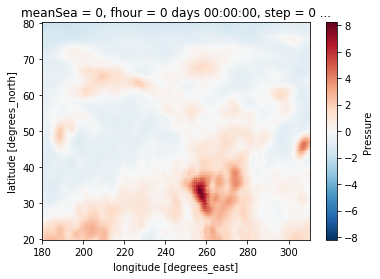

In [65]:
subset_vals['Pressure'][0].plot()

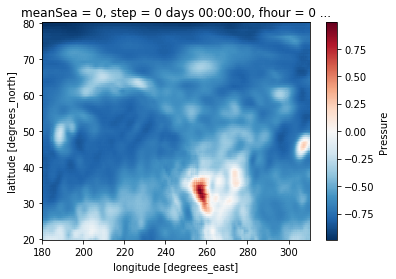

In [66]:
subset_vals_2 = (0.99-(-0.99))*(subset_vals-subset_vals.min(['lat','lon']))/(subset_vals.max(['lat','lon'])-subset_vals.min(['lat','lon'])) + -0.99
subset_vals_2['Pressure'][0].plot()

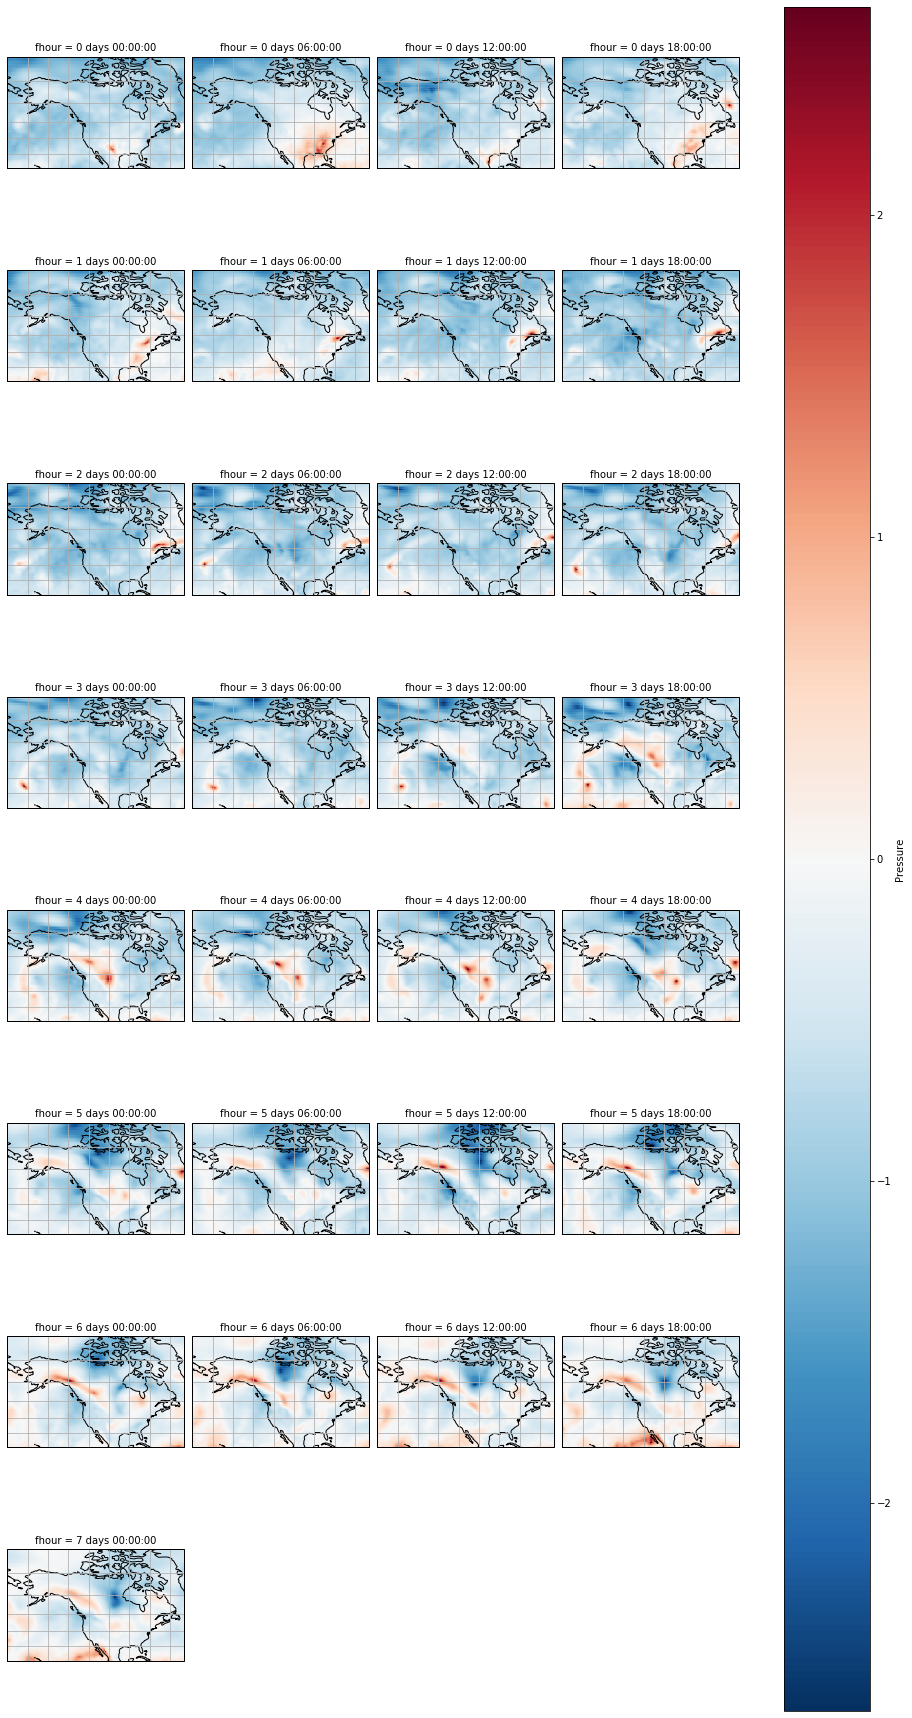

In [75]:
import cartopy.crs as ccrs

p=hsa_final['Pressure'].plot(x='lon', y='lat', col='fhour', col_wrap=4,transform=ccrs.PlateCarree(),subplot_kws={'projection': ccrs.Miller()})
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    ax.set_extent([-180,-50,20,65])

plt.draw()